In [1]:
import pandas as pd
import numpy as np

In [2]:
#读取数据，第一行作为columns，跳过第二行的中文说明字段
original_data=pd.read_csv("ecommerce_user_behavior_dataset.csv",header=0,skiprows=[1],encoding="gbk")
original_data.head()

,User_ID,Age,Gender,Location,Income,Interests,Last_Login_Days_Ago,Purchase_Frequency,Average_Order_Value,Total_Spending,Product_Category_Preference,Time_Spent_on_Site_Minutes,Pages_Viewed,Newsletter_Subscription
0,#1,56,Male,Suburban,38037,Sports,5,7,18,2546,Books,584,38,True
1,#2,46,Female,Rural,103986,Technology,15,7,118,320,Electronics,432,40,False
2,#3,32,Female,Suburban,101942,Sports,28,1,146,3766,Apparel,306,1,True
3,#4,60,Female,Suburban,71612,Fashion,18,3,163,4377,Apparel,527,29,False
4,#5,25,Male,Suburban,49725,Travel,2,5,141,4502,Health & Beauty,53,10,True


构建RFM模型，需要界定R(Recency),F(Frequency),M(Monetary)，分别衡量最近一次消费是在几天前？消费的频率如何？消费金额如何？其与客户价值的关系分别为，R为负相关，F为正相关，M为正相关。为便于处理，我们新定义一个r来替代R，满足r=-R，这样RFM三个因子都为正相关。

In [3]:
#实现自定义对多个列指标进行加权以构成核心R,F,M因子
#考虑到不同的指标间的数据量级差别较大，这里对namelist中的每个值都进行对数化处理
def composit_means(namelist,weight_list,group):
    """
    namelist是需要进行加权的列名列表
    weight_list是各个列名中的值对应的权重(索引一一对应,即namelist[a]的元素对应的权重为weight_list)
    group是你需要进行自定义加权处理的数据集，需要在分组后进行使用
    """
    if len(namelist)!=len(weight_list):
        Error1="Error,check the whether namelist and weight list has the same dimensions"
        return Error1
    if sum(weight_list)!=1:
        Error2="Error, check whether your weight_list has a sum of 1"
        return Error2
    weightedsum=0
    for name, weight in zip(namelist,weight_list):
        weightedsum+=np.log(group[name].mean())*weight
    return weightedsum

In [4]:
#进行RFM计算（这里注意下agg语法的书写要求）
#agg的语法为，输入一个字典，键为列名，值为计算方法，常见的有"count" "sum" "mean"······
RFM=original_data.groupby("User_ID").agg({"Last_Login_Days_Ago": "mean","Purchase_Frequency":"sum","Average_Order_Value":"sum"
                                          }).rename(columns={"Last_Login_Days_Ago":"Recency","Purchase_Frequency":"Frequency"
                                                            ,"Average_Order_Value":"Monetary"})
RFM["Recency"]=-RFM["Recency"]
print(RFM)

         Recency  Frequency  Monetary
User_ID                              
#1          -5.0          7        18
#10        -13.0          8        61
#100        -9.0          7        92
#1000      -12.0          7       175
#101       -29.0          5        51
...          ...        ...       ...
#995       -10.0          1        60
#996       -18.0          7        83
#997       -16.0          3       180
#998        -8.0          8       130
#999        -1.0          3       152

[1000 rows x 3 columns]


In [5]:
#下面是对自定义加权的测试
Mlist=["Income","Total_Spending","Average_Order_Value"]
weight=[0.2,0.3,0.5]
#计算RFM,这里用apply是因为agg返回的是series，无法支持我们进行自定义计算。
RFM_test = original_data.groupby("User_ID").apply(
    lambda group: pd.Series({
        "Recency": group["Last_Login_Days_Ago"].mean(),
        "Frequency": group["Purchase_Frequency"].sum(),
        "Monetary": composit_means(Mlist, weight, group)
    })
)

RFM_test["Recency"]=-RFM_test["Recency"]
print(RFM_test)

         Recency  Frequency  Monetary
User_ID                              
#1          -5.0        7.0  5.907132
#10        -13.0        8.0  6.952240
#100        -9.0        7.0  6.878207
#1000      -12.0        7.0  6.840940
#101       -29.0        5.0  6.087967
...          ...        ...       ...
#995       -10.0        1.0  5.877430
#996       -18.0        7.0  6.442719
#997       -16.0        3.0  6.716892
#998        -8.0        8.0  6.614837
#999        -1.0        3.0  6.795933

[1000 rows x 3 columns]


/tmp/ipykernel_47698/2443047354.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  RFM_test = original_data.groupby("User_ID").apply(


更进一步的，我们不用在composit函数中进行手动界定权重，可以通过PCA主成分分析，将概念上相关的几个因子合并成一个因子。这通常从数理上来看是更加“正确”的做法，但考虑到我们需要结合业务实际，故谨记可以composit的定义方法，实现自定义计算。

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
Mlist=["Income","Total_Spending","Average_Order_Value"]
#定义pca方法，用于对Monetary进行主成分分析
def pca_monetary(group,list):
    data=group[list].values
    #如果仅有一条有效记录，则直接返回其均值即可
    if data.shape[0] < 2:
        return np.mean(data)
    scaler=StandardScaler()
    data_scaled=scaler.fit_transform(data)
    #进行数据标准化
    pca=PCA(n_components=1)
    return pca.fit_transform(data_scaled).mean()
    #转换为单一有效因子。
RFM_pca=original_data.groupby("User_ID").apply(
    lambda group: pd.Series({
        "Recency": group["Last_Login_Days_Ago"].mean(),
        "Frequency": group["Purchase_Frequency"].sum(),
        "Monetary": pca_monetary(group,Mlist)
    })
)
RFM_pca["Recency"]=-RFM_pca["Recency"]
RFM_pca["Monetary"]=np.log(RFM_pca["Monetary"])
print(RFM_pca)

         Recency  Frequency   Monetary
User_ID                               
#1          -5.0        7.0   9.512936
#10        -13.0        8.0  10.650681
#100        -9.0        7.0   9.513034
#1000      -12.0        7.0  10.130809
#101       -29.0        5.0  10.050052
...          ...        ...        ...
#995       -10.0        1.0   9.452737
#996       -18.0        7.0  10.461693
#997       -16.0        3.0  10.410446
#998        -8.0        8.0  10.101997
#999        -1.0        3.0   9.919213

[1000 rows x 3 columns]


/tmp/ipykernel_47698/383489190.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  RFM_pca=original_data.groupby("User_ID").apply(


In [7]:
#检查PCA系数，判断标准化是否起效
user_monetary = original_data.groupby("User_ID")[Mlist].mean()
scaler = StandardScaler()
user_monetary_scaled = scaler.fit_transform(user_monetary)
pca = PCA(n_components=1)
pca.fit(user_monetary_scaled)
print("Overall PCA coefficients:", pca.components_)

Overall PCA coefficients: [[-0.47762148  0.6950147   0.5374312 ]]


接下来，基于最简单的RFM模型进行评分和分类分析。

In [8]:
#进行简单归类
#评分
RFM["R_score"]=pd.qcut(RFM["Recency"],q=5,labels=[1,2,3,4,5])
RFM["F_score"]=pd.qcut(RFM["Frequency"],q=5,labels=[1,2,3,4,5])
RFM["M_score"]=pd.qcut(RFM["Monetary"],q=5,labels=[1,2,3,4,5])
RFM["total_score"]=RFM["R_score"].astype(int) + RFM["F_score"].astype(int) + RFM["M_score"].astype(int)
print(RFM)

         Recency  Frequency  Monetary R_score F_score M_score  total_score
User_ID                                                                   
#1          -5.0          7        18       5       4       1           10
#10        -13.0          8        61       3       4       2            9
#100        -9.0          7        92       4       4       3           11
#1000      -12.0          7       175       4       4       5           13
#101       -29.0          5        51       1       3       2            6
...          ...        ...       ...     ...     ...     ...          ...
#995       -10.0          1        60       4       1       2            7
#996       -18.0          7        83       2       4       2            8
#997       -16.0          3       180       3       2       5           10
#998        -8.0          8       130       4       4       4           12
#999        -1.0          3       152       5       2       4           11

[1000 rows x 7 columns]


In [9]:
#进行分类，这里是根据总分进行类别分类（高价值，低价值，中价值分类）
def value_classify_rfm(row):
    if row["total_score"] >= 12:
        return "High Value"
    elif row["total_score"] >= 8:
        return "Medium Value"
    else:
        return "Low Value"
RFM["value_Classify"] = RFM.apply(value_classify_rfm, axis=1)

In [10]:
#进行活跃度分类，分为流失客户，活跃客户和潜在客户
"""
注意，在这里我们实际上可以再做一次PCA，针对Frequency和Recency进行合并
因为Frequency衡量的是购买频次，Recency衡量的是最近一次购买的时间间隔
两者都能够有效的对活跃度进行分析，故我们可以再进行一次PCA合并分析
"""
Activelist=["Recency","Frequency"]
user_activity = RFM.groupby("User_ID")[Activelist].mean()
scaler = StandardScaler()
user_activity_scaled = scaler.fit_transform(user_activity)
pca_activity = PCA(n_components=1)
pca_activity.fit(user_activity_scaled)
print(pca_activity.components_)
#由此我们可以得到一个活跃度的主成分分析结果
RFM["Activity_Score"] = pca_activity.transform(user_activity_scaled)


[[-0.70710678  0.70710678]]


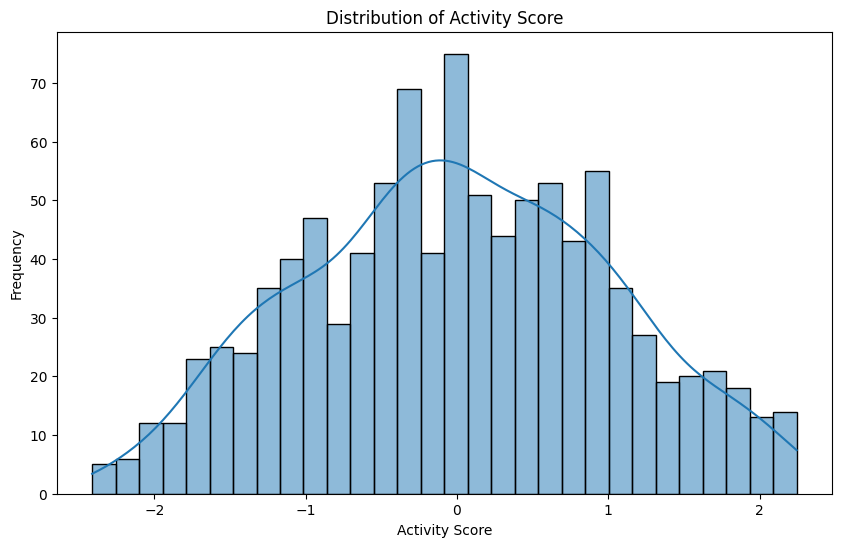

In [11]:
#进行可视化，画一个分布图
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(RFM['Activity_Score'], bins=30, kde=True)
plt.title('Distribution of Activity Score')
plt.ylabel('Frequency')
plt.xlabel("Activity Score")
plt.show()

In [13]:
#进行活跃度分类
def activity_classify(row):
    if row["Activity_Score"] >= 0.5:
        return "Active"
    elif row["Activity_Score"] >= -0.5:
        return "Potential"
    else:
        return "Churned"
RFM["Activity_Classify"] = RFM.apply(activity_classify, axis=1)
print(RFM)

         Recency  Frequency  Monetary R_score F_score M_score  total_score  \
User_ID                                                                      
#1          -5.0          7        18       5       4       1           10   
#10        -13.0          8        61       3       4       2            9   
#100        -9.0          7        92       4       4       3           11   
#1000      -12.0          7       175       4       4       5           13   
#101       -29.0          5        51       1       3       2            6   
...          ...        ...       ...     ...     ...     ...          ...   
#995       -10.0          1        60       4       1       2            7   
#996       -18.0          7        83       2       4       2            8   
#997       -16.0          3       180       3       2       5           10   
#998        -8.0          8       130       4       4       4           12   
#999        -1.0          3       152       5       2       4   